# Santander Customer Transaction Prediction 

In [33]:
# Importing Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import lightgbm as lgb
from sklearn.metrics import roc_auc_score,confusion_matrix,classification_report
from sklearn.model_selection import StratifiedKFold

In [5]:
# Loading Datasets
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

## Data Exploration

In [6]:
train_df.head()

,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,train_0,0,8.9255,-6.7863,11.9081,5.0930,11.4607,-9.2834,5.1187,18.6266,...,4.4354,3.9642,3.1364,1.6910,18.5227,-2.3978,7.8784,8.5635,12.7803,-1.0914
1,train_1,0,11.5006,-4.1473,13.8588,5.3890,12.3622,7.0433,5.6208,16.5338,...,7.6421,7.7214,2.5837,10.9516,15.4305,2.0339,8.1267,8.7889,18.3560,1.9518
2,train_2,0,8.6093,-2.7457,12.0805,7.8928,10.5825,-9.0837,6.9427,14.6155,...,2.9057,9.7905,1.6704,1.6858,21.6042,3.1417,-6.5213,8.2675,14.7222,0.3965
3,train_3,0,11.0604,-2.1518,8.9522,7.1957,12.5846,-1.8361,5.8428,14.9250,...,4.4666,4.7433,0.7178,1.4214,23.0347,-1.2706,-2.9275,10.2922,17.9697,-8.9996
4,train_4,0,9.8369,-1.4834,12.8746,6.6375,12.2772,2.4486,5.9405,19.2514,...,-1.4905,9.5214,-0.1508,9.1942,13.2876,-1.5121,3.9267,9.5031,17.9974,-8.8104


In [7]:
test_df.head()

,ID_code,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,test_0,11.0656,7.7798,12.9536,9.4292,11.4327,-2.3805,5.8493,18.2675,2.1337,...,-2.1556,11.8495,-1.4300,2.4508,13.7112,2.4669,4.3654,10.7200,15.4722,-8.7197
1,test_1,8.5304,1.2543,11.3047,5.1858,9.1974,-4.0117,6.0196,18.6316,-4.4131,...,10.6165,8.8349,0.9403,10.1282,15.5765,0.4773,-1.4852,9.8714,19.1293,-20.9760
2,test_2,5.4827,-10.3581,10.1407,7.0479,10.2628,9.8052,4.8950,20.2537,1.5233,...,-0.7484,10.9935,1.9803,2.1800,12.9813,2.1281,-7.1086,7.0618,19.8956,-23.1794
3,test_3,8.5374,-1.3222,12.0220,6.5749,8.8458,3.1744,4.9397,20.5660,3.3755,...,9.5702,9.0766,1.6580,3.5813,15.1874,3.1656,3.9567,9.2295,13.0168,-4.2108
4,test_4,11.7058,-0.1327,14.1295,7.7506,9.1035,-8.5848,6.8595,10.6048,2.9890,...,4.2259,9.1723,1.2835,3.3778,19.5542,-0.2860,-5.1612,7.2882,13.9260,-9.1846


In [8]:
#Train and test shapes
print(train_df.shape)
print(test_df.shape) 

(200000, 202)
(200000, 201)


 Observatons.
 Train set: 200,000 rows and 202 columns.
 Test set: 200,000 rows and 201 columns (test set does not have target column).

In [9]:
# looking for Object Datatype columns
trc = list(train_df.select_dtypes(['object']).columns)
tsc = list(test_df.select_dtypes(['object']).columns)
print(trc)
print(tsc)

['ID_code']
['ID_code']


Both sets have one object type column 

In [10]:
# checking for null values
train_df.isnull().values.any()

False

Train set has no null values

In [11]:
train_df.describe().T

,count,mean,std,min,25%,50%,75%,max
target,200000.0,0.100490,0.300653,0.0000,0.000000,0.00000,0.000000,1.0000
var_0,200000.0,10.679914,3.040051,0.4084,8.453850,10.52475,12.758200,20.3150
var_1,200000.0,-1.627622,4.050044,-15.0434,-4.740025,-1.60805,1.358625,10.3768
var_2,200000.0,10.715192,2.640894,2.1171,8.722475,10.58000,12.516700,19.3530
var_3,200000.0,6.796529,2.043319,-0.0402,5.254075,6.82500,8.324100,13.1883
...,...,...,...,...,...,...,...,...
var_195,200000.0,-0.142088,1.429372,-5.2610,-1.170700,-0.17270,0.829600,4.2729
var_196,200000.0,2.303335,5.454369,-14.2096,-1.946925,2.40890,6.556725,18.3215
var_197,200000.0,8.908158,0.921625,5.9606,8.252800,8.88820,9.593300,12.0004
var_198,200000.0,15.870720,3.010945,6.2993,13.829700,15.93405,18.064725,26.0791


In [12]:
test_df.describe().T

,count,mean,std,min,25%,50%,75%,max
var_0,200000.0,10.658737,3.036716,0.1887,8.442975,10.51380,12.739600,22.3234
var_1,200000.0,-1.624244,4.040509,-15.0434,-4.700125,-1.59050,1.343400,9.3851
var_2,200000.0,10.707452,2.633888,2.3552,8.735600,10.56070,12.495025,18.7141
var_3,200000.0,6.788214,2.052724,-0.0224,5.230500,6.82235,8.327600,13.1420
var_4,200000.0,11.076399,1.616456,5.4844,9.891075,11.09975,12.253400,16.0371
...,...,...,...,...,...,...,...,...
var_195,200000.0,-0.133657,1.429678,-4.9119,-1.160700,-0.16200,0.837900,4.5454
var_196,200000.0,2.290899,5.446346,-13.9442,-1.948600,2.40360,6.519800,15.9207
var_197,200000.0,8.912428,0.920904,6.1696,8.260075,8.89280,9.595900,12.2758
var_198,200000.0,15.869184,3.008717,6.5840,13.847275,15.94340,18.045200,26.5384


#### Standard deviation is relatively large for both train and test variable data;
#### min, max, mean, std values for train and test data looks quite close;
#### mean values are distributed over a large range.

### Target Column distribution

0    179902
1     20098
Name: target, dtype: int64


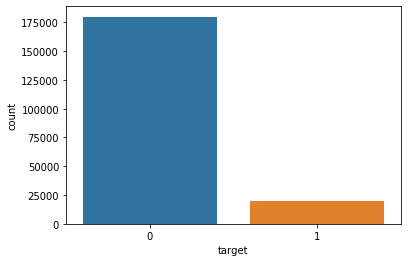

In [13]:
# Target variable distribution
sns.countplot(train_df['target'])
print(train_df['target'].value_counts())

The dataset is heavily imbalanced with respect to the target column.

### Train and Test sets distribution

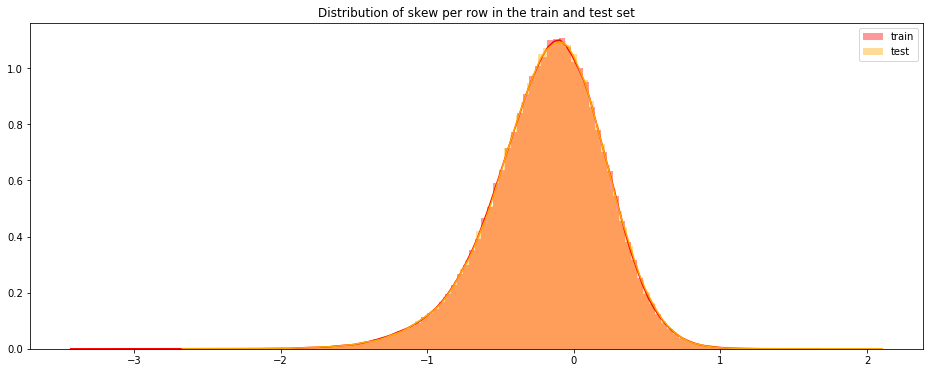

In [18]:
# Checking Skewness of train and test set
features = X.columns
plt.figure(figsize=(16,6))
plt.title("Distribution of skew per row in the train and test set")
sns.distplot(train_df[features].skew(axis=1),color="red", kde=True,bins=120, label='train')
sns.distplot(test_df[features].skew(axis=1),color="orange", kde=True,bins=120, label='test')
plt.legend()
plt.show()

#### As we can see here the datasets are negatively skewed

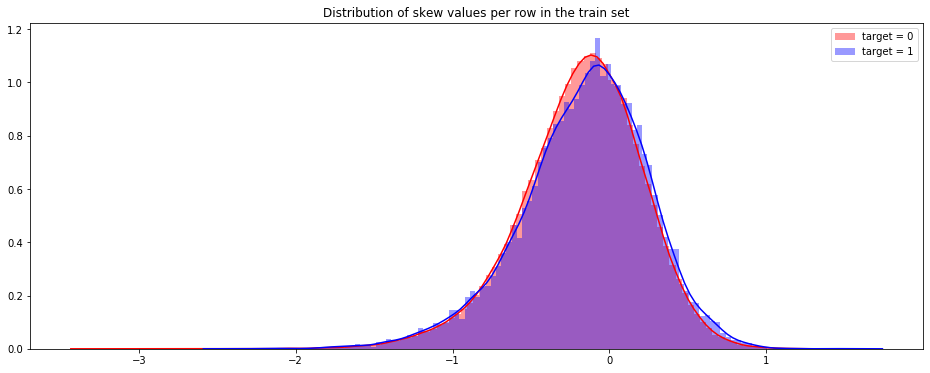

In [19]:
# Checking Skewness of 0 and 1 class of the Target column
t0 = train_df.loc[train_df['target'] == 0]
t1 = train_df.loc[train_df['target'] == 1]
plt.figure(figsize=(16,6))
plt.title("Distribution of skew values per row in the train set")
sns.distplot(t0[features].skew(axis=1),color="red", kde=True,bins=120, label='target = 0')
sns.distplot(t1[features].skew(axis=1),color="blue", kde=True,bins=120, label='target = 1')
plt.legend(); plt.show()

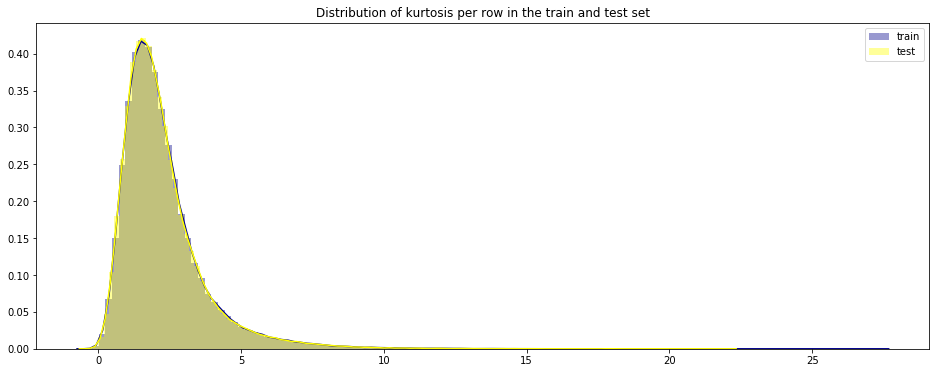

In [20]:
# Checking kurtosis of train and test sets
plt.figure(figsize=(16,6))
plt.title("Distribution of kurtosis per row in the train and test set")
sns.distplot(train_df[features].kurtosis(axis=1),color="darkblue", kde=True,bins=120, label='train')
sns.distplot(test_df[features].kurtosis(axis=1),color="yellow", kde=True,bins=120, label='test')
plt.legend()
plt.show()

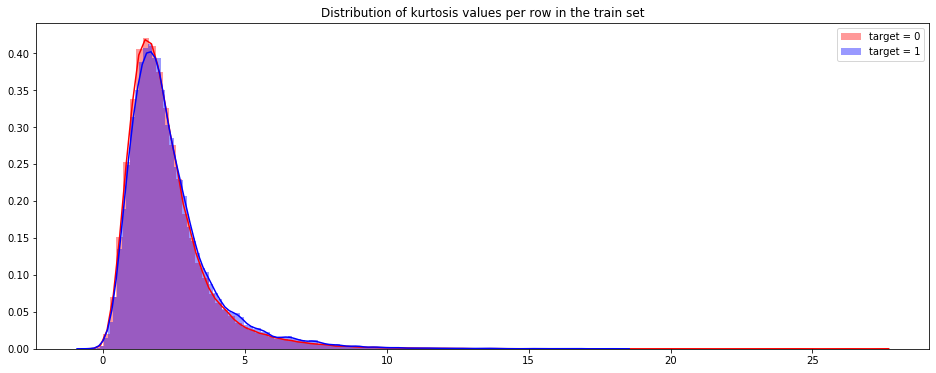

In [21]:
# Checking kurtosis of 0 and 1 class of the Target column
t0 = train_df.loc[train_df['target'] == 0]
t1 = train_df.loc[train_df['target'] == 1]
plt.figure(figsize=(16,6))
plt.title("Distribution of kurtosis values per row in the train set")
sns.distplot(t0[features].kurtosis(axis=1),color="red", kde=True,bins=120, label='target = 0')
sns.distplot(t1[features].kurtosis(axis=1),color="blue", kde=True,bins=120, label='target = 1')
plt.legend(); plt.show()

### Feature Correlations

In [22]:
def plotCorr(df,col,K=10,ascending = False):
    fig, ax = plt.subplots()
    fig.set_size_inches(14, 14)
    K=10
    corrmat = df.corr()
    cols = corrmat.nsmallest(K,'target')['target'].index if ascending else corrmat.nlargest(K,'target')['target'].index
    cm = np.corrcoef(df[cols].values.T)
    sns.heatmap(cm,cbar=True,annot=True,yticklabels=cols.values,xticklabels=cols.values,annot_kws={'size':10})
    plt.show()

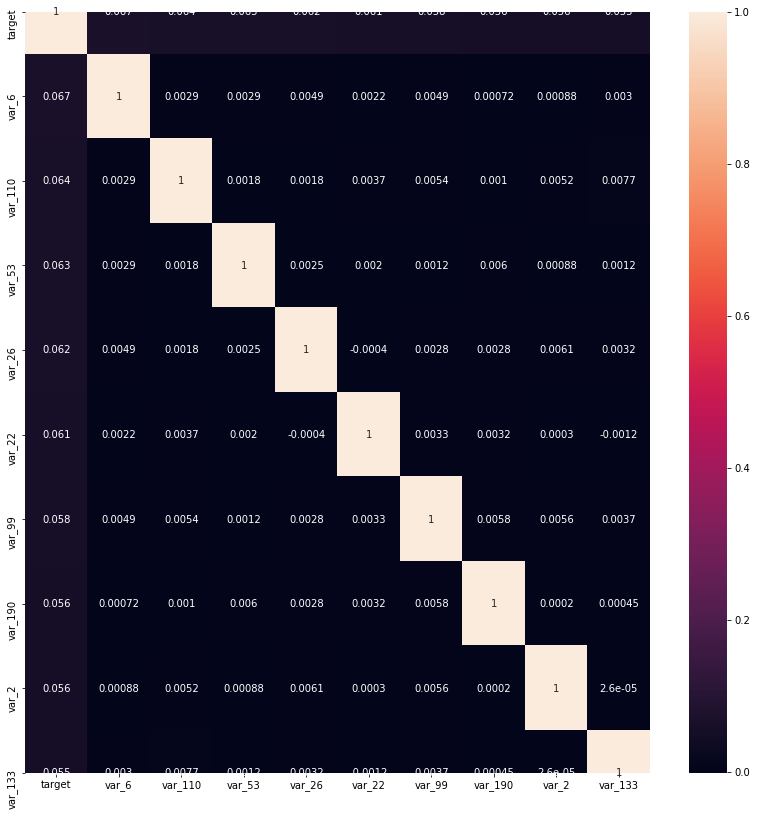

In [23]:
plotCorr(train_df,'target')

The highest correlation we observe is 0.067, which is a small value.

## Feature Engineering

In [16]:
idx = features = train_df.columns.values[2:202]
for df in [test_df, train_df]:
    df['sum'] = df[idx].sum(axis=1)  
    df['min'] = df[idx].min(axis=1)
    df['max'] = df[idx].max(axis=1)
    df['mean'] = df[idx].mean(axis=1)
    df['std'] = df[idx].std(axis=1)
    df['skew'] = df[idx].skew(axis=1)
    df['kurt'] = df[idx].kurtosis(axis=1)
    df['med'] = df[idx].median(axis=1)
    df['spread'] = df['max'] - df['min']
    df['spread_over_median'] = df['spread'] / df['med']
    df['spread_over_std'] = df['spread'] / df['std']

In [17]:
print(train_df.shape)
print(test_df.shape) 

(200000, 213)
(200000, 212)


## LightGBM

In [ ]:
#Since LightGBM had the highest auc-score of 0.76 among Logistic Regresssion, Naive Bayes, Random Forest & XGBoost.
#LightGBM has been choosen as the Model for this Dataset.

In [15]:
X=train_df.drop(['ID_code','target'],axis=1)
y=train_df['target']

#### Applying Hyper Parameter tuning for LGBM with bayesian Optimization

In [24]:
from bayes_opt import BayesianOptimization
from skopt  import BayesSearchCV 

def bayes_parameter_opt_lgb(X, y, init_round=15, opt_round=25, n_folds=3, random_seed=6,n_estimators=10000, output_process=False):
    # prepare data
    train_data = lgb.Dataset(data=X, label=y, free_raw_data=False)
    # parameters
    def lgb_eval(learning_rate,num_leaves, feature_fraction, bagging_fraction, max_depth, max_bin, min_data_in_leaf,min_sum_hessian_in_leaf,subsample):
        params = {'application':'binary', 'metric':'auc'}
        params['learning_rate'] = max(min(learning_rate, 1), 0)
        params["num_leaves"] = int(round(num_leaves))
        params['feature_fraction'] = max(min(feature_fraction, 1), 0)
        params['bagging_fraction'] = max(min(bagging_fraction, 1), 0)
        params['max_depth'] = int(round(max_depth))
        params['max_bin'] = int(round(max_depth))
        params['min_data_in_leaf'] = int(round(min_data_in_leaf))
        params['min_sum_hessian_in_leaf'] = min_sum_hessian_in_leaf
        params['subsample'] = max(min(subsample, 1), 0)
        
        cv_result = lgb.cv(params, train_data, nfold=n_folds, seed=random_seed, stratified=True, verbose_eval =200, metrics=['auc'])
        return max(cv_result['auc-mean'])
     
    lgbBO = BayesianOptimization(lgb_eval, {'learning_rate': (0.01, 1.0),
                                            'num_leaves': (24, 80),
                                            'feature_fraction': (0.1, 0.9),
                                            'bagging_fraction': (0.8, 1),
                                            'max_depth': (5, 30),
                                            'max_bin':(20,90),
                                            'min_data_in_leaf': (20, 80),
                                            'min_sum_hessian_in_leaf':(0,100),
                                           'subsample': (0.01, 1.0)}, random_state=200)

    
    #n_iter: How many steps of bayesian optimization you want to perform. The more steps the more likely to find a good maximum you are.
    #init_points: How many steps of random exploration you want to perform. Random exploration can help by diversifying the exploration space.
    
    lgbBO.maximize(init_points=init_round, n_iter=opt_round)
    
    model_auc=[]
    for model in range(len( lgbBO.res)):
        model_auc.append(lgbBO.res[model]['target'])
    
    # return best parameters
    return lgbBO.res[pd.Series(model_auc).idxmax()]['target'],lgbBO.res[pd.Series(model_auc).idxmax()]['params']

opt_params = bayes_parameter_opt_lgb(X, y, init_round=5, opt_round=10, n_folds=3, random_seed=6,n_estimators=10000)

        

|   iter    |  target   | baggin... | featur... | learni... |  max_bin  | max_depth | min_da... | min_su... | num_le... | subsample |
-------------------------------------------------------------------------------------------------------------------------------------
[LightGBM] [Warning] bagging_fraction is set=0.9895264513703341, subsample=0.4615201756036703 will be ignored. Current value: bagging_fraction=0.9895264513703341
[LightGBM] [Warning] bagging_fraction is set=0.9895264513703341, subsample=0.4615201756036703 will be ignored. Current value: bagging_fraction=0.9895264513703341
[LightGBM] [Warning] bagging_fraction is set=0.9895264513703341, subsample=0.4615201756036703 will be ignored. Current value: bagging_fraction=0.9895264513703341
[LightGBM] [Info] Number of positive: 13399, number of negative: 119934
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.086302 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM

[LightGBM] [Warning] bagging_fraction is set=0.8192059420307759, subsample=0.4252313651032907 will be ignored. Current value: bagging_fraction=0.8192059420307759
[LightGBM] [Warning] bagging_fraction is set=0.8192059420307759, subsample=0.4252313651032907 will be ignored. Current value: bagging_fraction=0.8192059420307759
[LightGBM] [Info] Number of positive: 13398, number of negative: 119935
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.072300 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5400
[LightGBM] [Info] Number of data points in the train set: 133333, number of used features: 200
[LightGBM] [Warning] bagging_fraction is set=0.8192059420307759, subsample=0.4252313651032907 will be ignored. Current value: bagging_fraction=0.8192059420307759
[LightGBM] [Warning] bagging_fraction is set=0.8192059420307759, subsample=0.4252313651032907 will be ignored. Current value: bagging_fraction=0.819

[LightGBM] [Warning] bagging_fraction is set=0.994565837939734, subsample=0.8559475937048635 will be ignored. Current value: bagging_fraction=0.994565837939734
[LightGBM] [Warning] bagging_fraction is set=0.994565837939734, subsample=0.8559475937048635 will be ignored. Current value: bagging_fraction=0.994565837939734
[LightGBM] [Info] Number of positive: 13399, number of negative: 119935
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.103535 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2000
[LightGBM] [Info] Number of data points in the train set: 133334, number of used features: 200
[LightGBM] [Warning] bagging_fraction is set=0.994565837939734, subsample=0.8559475937048635 will be ignored. Current value: bagging_fraction=0.994565837939734
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.100493 -> initscore=-2.191762
[LightGBM] [Info] Start training from score -2.191762
[LightGBM] [Info] [b

[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.100493 -> initscore=-2.191762
[LightGBM] [Info] Start training from score -2.191762
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.100485 -> initscore=-2.191844
[LightGBM] [Info] Start training from score -2.191844
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.100492 -> initscore=-2.191770
[LightGBM] [Info] Start training from score -2.191770
|  7        |  0.8663   |  0.8781   |  0.6065   |  0.2331   |  88.07    |  17.2     |  60.71    |  22.78    |  27.33    |  0.7911   |
[LightGBM] [Warning] bagging_fraction is set=0.8781134977262339, subsample=0.7910710320640456 will be ignored. Current value: bagging_fraction=0.8781134977262339
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will

[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Info] Number of positive: 13399, number of negative: 119935
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.104046 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2400
[LightGBM] [Info] Number of data points in the train set: 133334, number of used features: 200
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.100493 -> initscore=-2.191762
[LightGBM] [Info] Start training from score -2.191762
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.100485 -> initscore=-2.191844
[LightGBM] [Info] Start training from score -2.191844
[LightGBM] [Inf

[LightGBM] [Warning] bagging_fraction is set=0.923074759556337, subsample=0.5878780267372351 will be ignored. Current value: bagging_fraction=0.923074759556337
[LightGBM] [Info] Number of positive: 13399, number of negative: 119934
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.114672 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3200
[LightGBM] [Info] Number of data points in the train set: 133333, number of used features: 200
[LightGBM] [Warning] bagging_fraction is set=0.923074759556337, subsample=0.5878780267372351 will be ignored. Current value: bagging_fraction=0.923074759556337
[LightGBM] [Warning] bagging_fraction is set=0.923074759556337, subsample=0.5878780267372351 will be ignored. Current value: bagging_fraction=0.923074759556337
[LightGBM] [Warning] bagging_fraction is set=0.923074759556337, subsample=0.5878780267372351 will be ignored. Current value: bagging_fraction=0.9230747595

[LightGBM] [Warning] bagging_fraction is set=0.839583152783098, subsample=0.6909395859598756 will be ignored. Current value: bagging_fraction=0.839583152783098
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 13398, number of negative: 119935
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.077561 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3000
[LightGBM] [Info] Number of data points in the train set: 133333, number of used features: 200
[LightGBM] [Warning] bagging_fraction is set=0.839583152783098, subsample=0.6909395859598756 will be ignored. Current value: bagging_fraction=0.839583152783098
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] bagging_fraction is set=0.8395831

In [25]:
opt_params[1]["num_leaves"] = int(round(opt_params[1]["num_leaves"]))
opt_params[1]['max_depth'] = int(round(opt_params[1]['max_depth']))
opt_params[1]['min_data_in_leaf'] = int(round(opt_params[1]['min_data_in_leaf']))
opt_params[1]['max_bin'] = int(round(opt_params[1]['max_bin']))
opt_params[1]['objective']='binary'
opt_params[1]['metric']='auc'
opt_params[1]['is_unbalance']=True
opt_params[1]['boost_from_average']=False
opt_params=opt_params[1]

In [26]:
opt_params

{'bagging_fraction': 0.8781134977262339,
 'feature_fraction': 0.6065348111276945,
 'learning_rate': 0.23309577418111851,
 'max_bin': 88,
 'max_depth': 17,
 'min_data_in_leaf': 61,
 'min_sum_hessian_in_leaf': 22.779543211184816,
 'num_leaves': 27,
 'subsample': 0.7910710320640456,
 'objective': 'binary',
 'metric': 'auc',
 'is_unbalance': True,
 'boost_from_average': False}

In [27]:

target = train_df['target']
param = {
    'bagging_freq': 5,  
    'bagging_fraction': 0.8781134977262339,
    'boost_from_average':'false',
    'boost': 'gbdt',   
    'feature_fraction': 0.6065348111276945,
    'learning_rate': 0.23309577418111851,
    'max_depth': 17,
    'max_bin': 88,
    'metric':'auc',
    'min_data_in_leaf': 61,     
    'min_sum_hessian_in_leaf': 22.779543211184816,
    'num_leaves': 27,           
    'objective': 'binary', 
    'is_unbalance': True,
    'verbosity': 1
}


#### LightBGM with StratifiedKFold

In [28]:
folds = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)
oof = np.zeros(len(train_df))
predictions = np.zeros(len(test_df))


In [29]:
for fold_, (trn_idx, val_idx) in enumerate(folds.split(X, y)):
    print("Fold {}".format(fold_))
    trn_data = lgb.Dataset(train_df.iloc[trn_idx][features], label=target.iloc[trn_idx])
    val_data = lgb.Dataset(train_df.iloc[val_idx][features], label=target.iloc[val_idx])
    clf = lgb.train(param, trn_data, 7000, valid_sets = [trn_data, val_data], verbose_eval=5000, early_stopping_rounds = 700)
    oof[val_idx] = clf.predict(train_df.iloc[val_idx][features], num_iteration=clf.best_iteration)
    predictions += clf.predict(test_df[features], num_iteration=clf.best_iteration) / folds.n_splits
print("CV score: {:<8.5f}".format(roc_auc_score(target, oof)))


Fold 0
[LightGBM] [Info] Number of positive: 18089, number of negative: 161911
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.167824 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 17600
[LightGBM] [Info] Number of data points in the train set: 180000, number of used features: 200
Training until validation scores don't improve for 700 rounds
Early stopping, best iteration is:
[171]	training's auc: 0.95975	valid_1's auc: 0.882257
Fold 1
[LightGBM] [Info] Number of positive: 18089, number of negative: 161911
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.149128 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 17600
[LightGBM] [Info] Number of data points in the train set: 180000, number of used features: 200
Training until validation scores don't improve for 700 rounds
Early stopping, best iteration is:
[198

In [ ]:
sub = pd.DataFrame({"ID_code": test_df.ID_code.values})
sub["target"] = predictions
sub.to_csv("submission1.csv", index=False)

In [36]:
pre = np.round(oof)
print(confusion_matrix(target, pre))

[[154606  25296]
 [  5375  14723]]


In [37]:
print(classification_report(target, pre))

              precision    recall  f1-score   support

           0       0.97      0.86      0.91    179902
           1       0.37      0.73      0.49     20098

    accuracy                           0.85    200000
   macro avg       0.67      0.80      0.70    200000
weighted avg       0.91      0.85      0.87    200000

